### 1. Import Dependecies

In [229]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt

### 2. Loading the data

In [230]:
X_train = np.load('../artifacts/X_train.npz')['arr_0']
Y_train = np.load('../artifacts/Y_train.npz')['arr_0']
X_test = np.load('../artifacts/X_test.npz')['arr_0']
Y_test = np.load('../artifacts/Y_test.npz')['arr_0']

### 3. Model Training

#### 3.1 Logistic Regression

##### 3.1.1 simple Logistic regression

In [231]:
model_none = LogisticRegression(
    penalty=None,          
    max_iter=1000
)

In [232]:
model_none.fit(X_train, Y_train)

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


##### 3.1.2 L1 Regularization

In [233]:
model_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',    
    C=1.0,              
    max_iter=1000
)

In [234]:
model_l1.fit(X_train, Y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


##### L2 Regularization

In [235]:
model_l2 = LogisticRegression(
    penalty='l2',
    solver='lbfgs',       
    C=1.0,
    max_iter=1000
)

In [236]:
model_l2.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### 3.2  Bagging Approach

##### 3.2.1 Random Forest (bagging approach)

In [237]:
rf_model = RandomForestClassifier(
    n_estimators=100,   
    max_depth=None,     
    random_state=42,
    bootstrap=True    
)

In [238]:
rf_model.fit(X_train, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### 3.3 Boosting Methods 

##### 3.3.1 AdaBoost

In [239]:
adaBoost_model = AdaBoostClassifier(
                n_estimators=100, 
                random_state=42
)

In [240]:
adaBoost_model.fit(X_train, Y_train)

,estimator,None
,n_estimators,100
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


##### 3.3.2 XGBoost

In [241]:
XGBoost_model = XGBClassifier(
    n_estimators=100, 
    random_state=42,  
    eval_metric="logloss"
)

In [242]:
XGBoost_model.fit(X_train, Y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


##### 3.3.3 CatBoost

In [243]:
CatBoost_model = CatBoostClassifier(
    n_estimators=100, 
    random_state=42, 
    logging_level='Silent',  # disables console output
    train_dir=None
) 

In [244]:
CatBoost_model.fit(X_train, Y_train)

### 4. Evaluation Matrices 

In [245]:
models = {
    "No Regularization": model_none,
    "L1 Regularization": model_l1,
    "L2 Regularization": model_l2,
    "Random Forest":rf_model,
    "AdaBoost":adaBoost_model,
    "XGBoost":XGBoost_model,
    "CatBoost":CatBoost_model
}

In [246]:
results = []

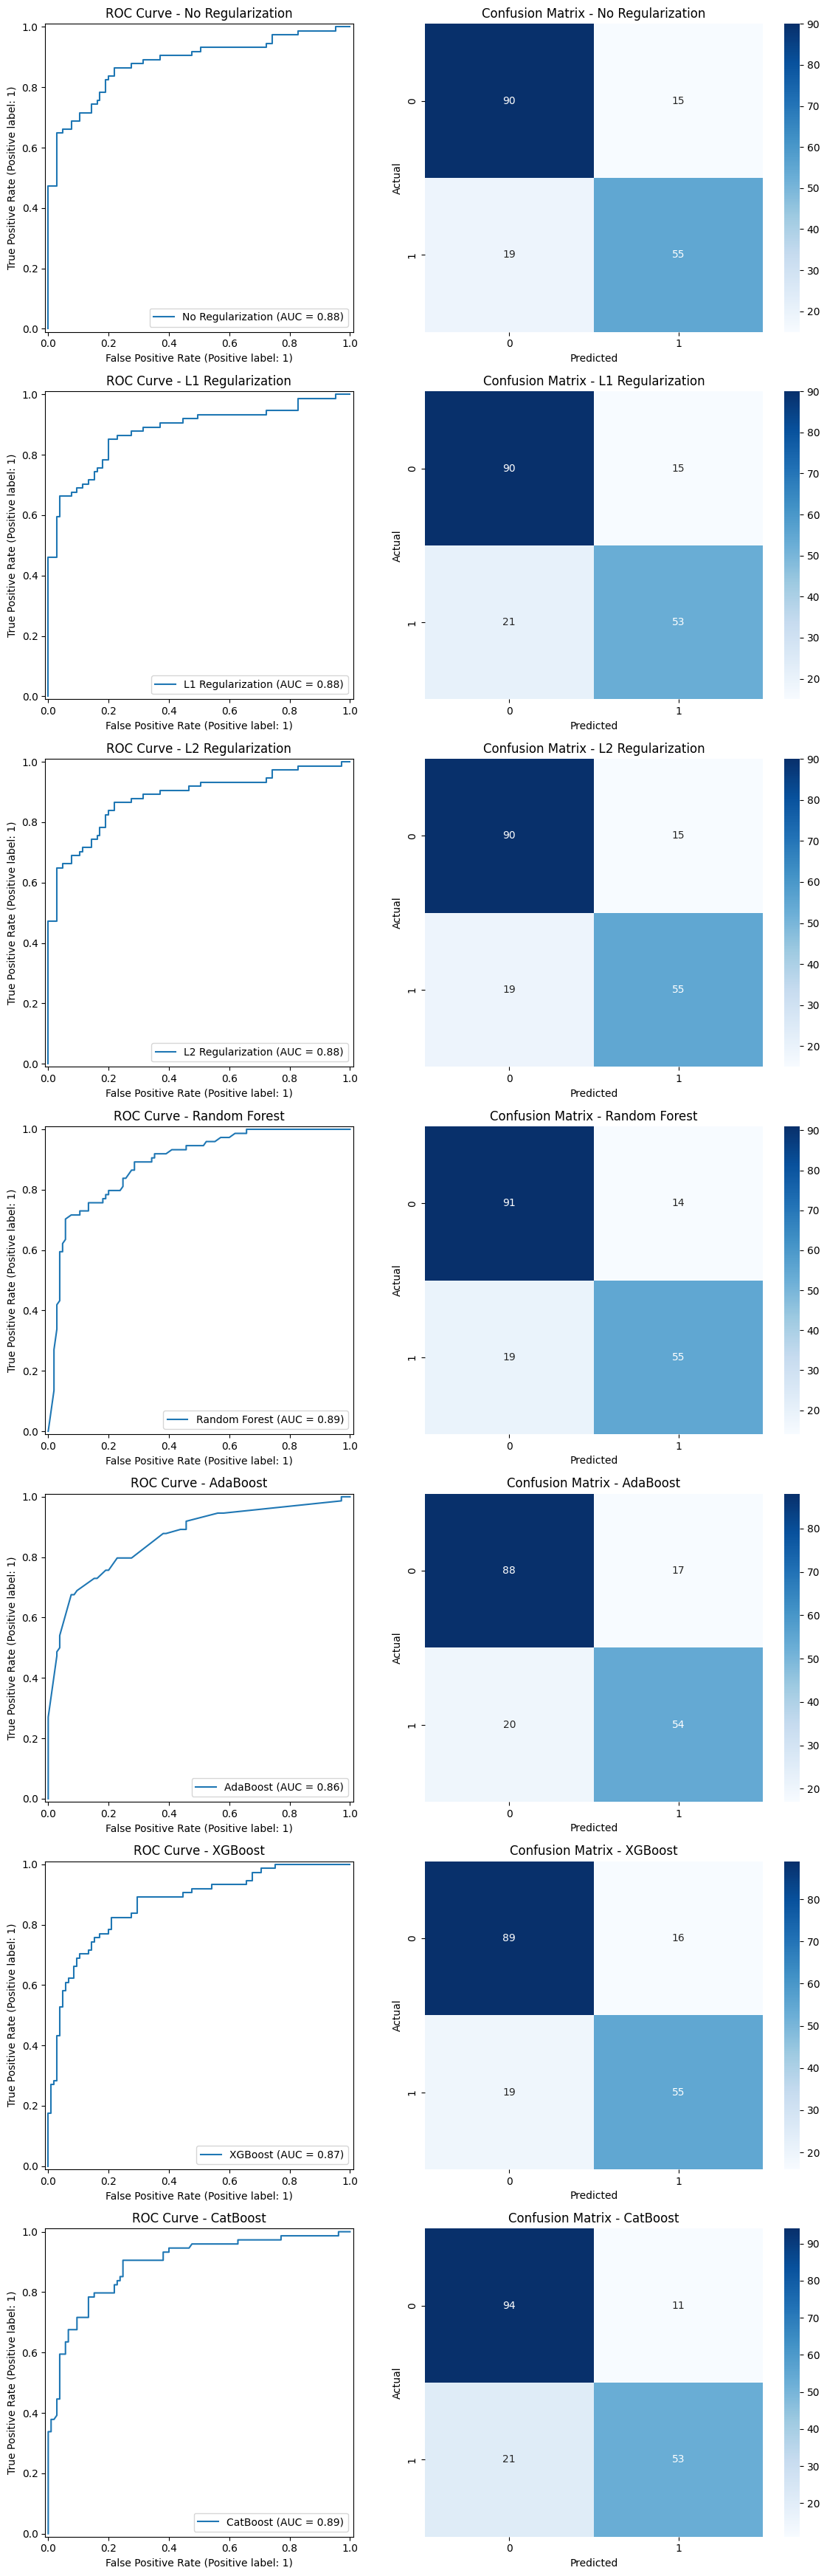

In [247]:
n_models = len(models)
fig, axes = plt.subplots(n_models, 2, figsize=(12, 5*n_models))

for i, (name, model) in enumerate(models.items()):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_proba)
    cm = confusion_matrix(Y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

    RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=axes[i,0], name=name)
    axes[i,0].set_title(f"ROC Curve - {name}")


    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i,1])
    axes[i,1].set_title(f"Confusion Matrix - {name}")
    axes[i,1].set_xlabel("Predicted")
    axes[i,1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [248]:

df_results = pd.DataFrame(results)
df_results = df_results.round(3)
df_results

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,No Regularization,0.810,0.786,0.743,0.764,0.882
1,L1 Regularization,0.799,0.779,0.716,0.746,0.878
2,L2 Regularization,0.810,0.786,0.743,0.764,0.882
3,Random Forest,0.816,0.797,0.743,0.769,0.888
4,AdaBoost,0.793,0.761,0.730,0.745,0.864
5,XGBoost,0.804,0.775,0.743,0.759,0.871
6,CatBoost,0.821,0.828,0.716,0.768,0.893


### 5. Comparision Table

In [249]:
from_scratch_results = {
    'Model': ['Logistic Regression', 'L1 Logistic', 'L2 Logistic', 'Bagging','Boosting'],
    'Precision': [0.803,0.764, 0.830,0.825,0.791],
    'Recall': [0.716, 0.702, 0.729, 0.702,0.716],
    'F1 Score': [0.757, 0.732, 0.776, 0.759,0.751],
    'Accuracy': [0.810, 0.787, 0.826, 0.815,0.804],
    'AUC': [0.867, 0.861, 0.880, 0.876,0.863]
}


library_results = {
    'Model': ['Logistic Regression', 'L1 Logistic', 'L2 Logistic', 'Bagging','Boosting'],
    'Precision': [0.786, 0.779, 0.786, 0.797,0.761],
    'Recall': [0.743, 0.716, 0.743, 0.743,0.730],
    'F1 Score': [0.764, 0.746, 0.764, 0.769,0.745],
    'Accuracy': [0.810, 0.799, 0.810, 0.816,0.793],
    'AUC': [0.882, 0.878, 0.882, 0.888,0.864]
}


In [ ]:
df_from_scratch = pd.DataFrame(from_scratch_results)
df_library = pd.DataFrame(library_results)


comparison_df = pd.concat([df_from_scratch.set_index('Model'), df_library.set_index('Model')],
                          axis=1, keys=['From-Scratch', 'Library'])


comparison_df

From-Scratch                                   Library  \
                       Precision Recall F1 Score Accuracy    AUC Precision   
Model                                                                        
Logistic Regression        0.803  0.716    0.757    0.810  0.867     0.786   
L1 Logistic                0.764  0.702    0.732    0.787  0.861     0.779   
L2 Logistic                0.830  0.729    0.776    0.826  0.880     0.786   
Bagging                    0.825  0.702    0.759    0.815  0.876     0.797   
Boosting                   0.791  0.716    0.751    0.804  0.863     0.761   

                                                     
                    Recall F1 Score Accuracy    AUC  
Model                                                
Logistic Regression  0.743    0.764    0.810  0.882  
L1 Logistic          0.716    0.746    0.799  0.878  
L2 Logistic          0.743    0.764    0.810  0.882  
Bagging              0.743    0.769    0.816  0.888  
Boosting             0.730    0.745    0.793  0.864